<a href="https://colab.research.google.com/github/shivammehta007/Machine-Learning-Lab/blob/master/Data%20Analysis%20Task/Data-Analysis-Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem :
## Jaipur Rainfall Data
#### The problem is that Jaipur is one of the regions in India that has very limited amount of rainfall throught the year, So we will try to implement data analysis to predict what amount of rainfall will be recieved

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import MinMaxScaler


import keras
from keras.layers.core import Dense, Dropout
from keras.layers import Input , LSTM, Embedding
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.regularizers import l2

from os.path import join


Using TensorFlow backend.


In [0]:
SEED = 1234
from numpy.random import seed
seed(SEED)
from tensorflow import set_random_seed
set_random_seed(SEED)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
dataset = '/content/gdrive/My Drive/Colab Notebooks/DataSet-Jaipur'

# Location of Dataset
# dataset = 'DataSet-Jaipur'
filename = 'JaipurRawData.csv'
filename = join(dataset, filename)

In [5]:
df = pd.read_csv(filename, index_col='date')
df.head()

,meantempm,meandewptm,meanpressurem,maxhumidity,minhumidity,maxtempm,mintempm,maxdewptm,mindewptm,maxpressurem,minpressurem,precipm
date,,,,,,,,,,,,
2016-05-01,34,-1,1005.63,24,4,43,26,9,-10,1009,999,0.0
2016-05-02,36,4,1005.46,21,6,43,29,10,-2,1008,1001,0.0
2016-05-03,35,6,1006.00,27,5,41,29,12,-2,1009,1000,0.0
2016-05-04,34,7,1005.65,29,6,41,27,13,0,1008,1001,0.0
2016-05-05,31,11,1007.94,61,13,38,24,16,6,1011,1003,5.0


In [6]:
print('Shape of Dataset: {}'.format(df.shape))
print('Shape of Each Row: {}'.format(df.iloc[0].shape))
print(df.dtypes)

Shape of Dataset: (679, 12)
Shape of Each Row: (12,)
meantempm          int64
meandewptm         int64
meanpressurem    float64
maxhumidity        int64
minhumidity        int64
maxtempm           int64
mintempm           int64
maxdewptm          int64
mindewptm          int64
maxpressurem       int64
minpressurem       int64
precipm          float64
dtype: object


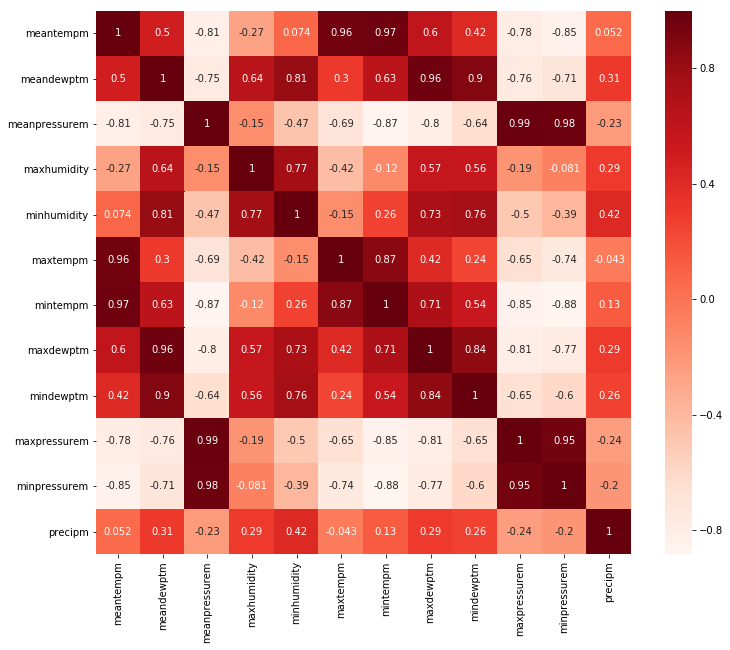

In [7]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.savefig('correlationheatmap.png')
plt.show()


### Feature Engineering

In [0]:
def min_max_to_mean(df, input_columns, output_columnname):
    df[output_columnname] = (df[input_columns[0]] + df[input_columns[1]])/ 2
    df.drop(input_columns, axis=1, inplace=True)
    return df

In [0]:
df = min_max_to_mean(df, ['maxhumidity', 'minhumidity'], 'meanhumidity')
df.drop(['maxtempm', 'mintempm', 'maxdewptm', 'mindewptm', 'maxpressurem', 'minpressurem'], axis=1, inplace=True)

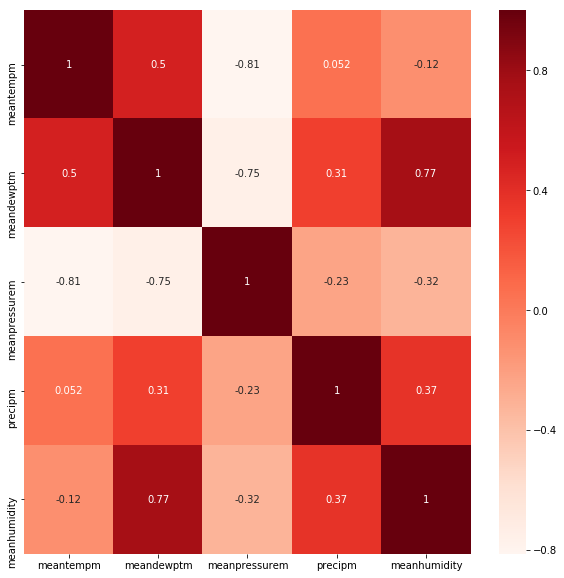

In [10]:
plt.figure(figsize=(10,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.savefig('correlationheatmap.png')
plt.show()


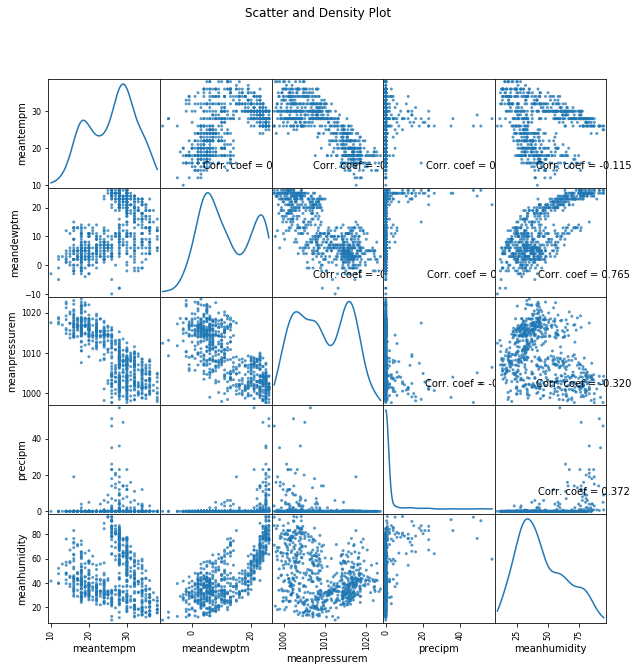

In [11]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number])
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] 
    columnNames = list(df)
    if len(columnNames) > 10: 
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.savefig('scatterplot.png')

    plt.show()

    
plotScatterMatrix(df, 10, 10)


##### We see that Maximum Correlation is from Humidity and Dew Point, Looking at their distribution

In [0]:
def showplots(x):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(x, ax=ax_box)
    sns.distplot(x, ax=ax_hist)
    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

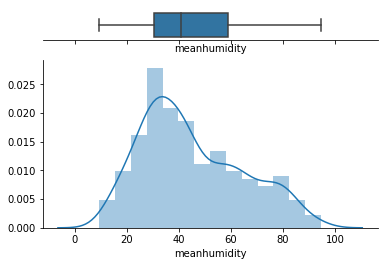

In [13]:
showplots(df['meanhumidity'])

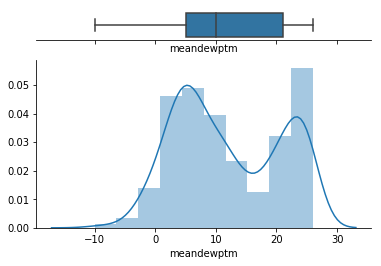

In [14]:
showplots(df['meandewptm'])

##### Thus There were no outliners as such, data comes from a distribution

### Normalizing the Data we get

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

In [0]:
df = pd.DataFrame(df_scaled, columns=df.columns)

##### Pad Historic data for past 2 days with each row

In [0]:
def pad_nth_day_feature(df, feature, N):
    rows = df.shape[0]
    nth_prior_meassurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_meassurements

In [18]:
df.columns

Index(['meantempm', 'meandewptm', 'meanpressurem', 'precipm', 'meanhumidity'], dtype='object')

In [0]:
for column in df.columns:
#     if column != 'precipm':
    for n in range(1, 3):
        pad_nth_day_feature(df, column, n)

In [20]:
df.head()

,meantempm,meandewptm,meanpressurem,precipm,meanhumidity,meantempm_1,meantempm_2,meandewptm_1,meandewptm_2,meanpressurem_1,meanpressurem_2,precipm_1,precipm_2,meanhumidity_1,meanhumidity_2
0,0.857143,0.250000,0.310078,0.000000,0.052941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.928571,0.388889,0.303488,0.000000,0.047059,0.857143,NaN,0.250000,NaN,0.310078,NaN,0.0,NaN,0.052941,NaN
2,0.892857,0.444444,0.324419,0.000000,0.076471,0.928571,0.857143,0.388889,0.250000,0.303488,0.310078,0.0,0.0,0.047059,0.052941
3,0.857143,0.472222,0.310853,0.000000,0.094118,0.892857,0.928571,0.444444,0.388889,0.324419,0.303488,0.0,0.0,0.076471,0.047059
4,0.750000,0.583333,0.399612,0.087719,0.323529,0.857143,0.892857,0.472222,0.444444,0.310853,0.324419,0.0,0.0,0.094118,0.076471


In [21]:
# Changes in Shape
print('Shape of Dataset: {}'.format(df.shape))
print('Shape of Each Row: {}'.format(df.iloc[0].shape))

Shape of Dataset: (679, 15)
Shape of Each Row: (15,)


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 15 columns):
meantempm          679 non-null float64
meandewptm         679 non-null float64
meanpressurem      679 non-null float64
precipm            679 non-null float64
meanhumidity       679 non-null float64
meantempm_1        678 non-null float64
meantempm_2        677 non-null float64
meandewptm_1       678 non-null float64
meandewptm_2       677 non-null float64
meanpressurem_1    678 non-null float64
meanpressurem_2    677 non-null float64
precipm_1          678 non-null float64
precipm_2          677 non-null float64
meanhumidity_1     678 non-null float64
meanhumidity_2     677 non-null float64
dtypes: float64(15)
memory usage: 79.6 KB


##### Doing Some Data Cleaning Operations

In [0]:
# Check if there is only one value in the column remove that feature
def check_uniqueness(dataframe):
    for column in dataframe.columns:
        if len(pd.Series.unique(dataframe[column])) == 1:
            dataframe.drop(column, inplace=True, axis=1)

            
    return dataframe

df = check_uniqueness(df)

In [0]:
# Drop Na Columns
df.dropna(inplace=True)

In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
meantempm,677.0,0.573802,0.221925,0.0,0.357143,0.642857,0.714286,1.0
meandewptm,677.0,0.610619,0.242542,0.0,0.416667,0.555556,0.861111,1.0
meanpressurem,677.0,0.460274,0.251097,0.0,0.235271,0.434884,0.693411,1.0
precipm,677.0,0.021908,0.095296,0.0,0.000000,0.000000,0.000000,1.0
meanhumidity,677.0,0.418777,0.229411,0.0,0.247059,0.370588,0.582353,1.0
meantempm_1,677.0,0.574330,0.222343,0.0,0.357143,0.642857,0.714286,1.0
meantempm_2,677.0,0.574752,0.222609,0.0,0.357143,0.642857,0.714286,1.0
meandewptm_1,677.0,0.610660,0.242502,0.0,0.416667,0.555556,0.861111,1.0
meandewptm_2,677.0,0.610455,0.242749,0.0,0.416667,0.555556,0.861111,1.0
meanpressurem_1,677.0,0.459843,0.251115,0.0,0.235271,0.433333,0.693411,1.0


### Preparing Data

For Precipitation Prediction

In [0]:
y_data = df['precipm']
x_data = df.drop(['precipm'], axis=1)

In [27]:
print('Shape of X: {}'.format(x_data.shape))
print('Shape of Y: {}'.format(y_data.shape))

Shape of X: (677, 14)
Shape of Y: (677,)


#### Split Train and Test Data


In [0]:
# Split into Training and Test Set
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=SEED)

In [0]:
# Change them all to numpy array for faster computation
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [30]:
# Print Final Shapes of Sets
print('Training Set : X -> {}, Y -> {}'.format(x_train.shape, y_train.shape))
print('Testing Set: X -> {}, Y -> {}'.format(x_test.shape, y_test.shape))

Training Set : X -> (541, 14), Y -> (541,)
Testing Set: X -> (136, 14), Y -> (136,)


#### Now we have Training Set and Testing Set

##### Applying RandomForestRegressor

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [32]:
rfg = RandomForestRegressor(random_state=SEED)
rfg.fit(x_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=1234,
                      verbose=0, warm_start=False)

In [0]:
y_test_pred = rfg.predict(x_test)

In [34]:
# Root Mean Square Error
rmf_rmse = np.round(np.sqrt(mean_squared_error(y_test,y_test_pred)), 5)
print('Root Mean Square Error: {}'.format(rmf_rmse))

Root Mean Square Error: 0.09167


##### 1. Applying Linear Regression

In [35]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
y_test_predicted = lin_reg.predict(x_test)

In [37]:
# Root Mean Square Error
lin_rmse = np.round(np.sqrt(mean_squared_error(y_test,y_test_predicted)), 5)
print('Root Mean Square Error: {}'.format(lin_rmse))


Root Mean Square Error: 0.04875


##### 2. Fitting Polynomial Regression

In [0]:
from sklearn.preprocessing import PolynomialFeatures

In [0]:
polynomial_history = []

In [0]:
degree_array = [2,4,5]

In [41]:
for degree in degree_array:

    polynomial_features= PolynomialFeatures(degree=degree)
    x_train_poly = polynomial_features.fit_transform(x_train)
    x_test_poly = polynomial_features.fit_transform(x_test)
    lin_reg = LinearRegression()
    lin_reg.fit(x_train_poly, y_train)
    y_test_poly_predicted = lin_reg.predict(x_test_poly)
    rmse = np.round(np.sqrt(mean_squared_error(y_test, y_test_poly_predicted)), 5)
    print('Root Mean Square Error: {}'.format(rmse))
    
    polynomial_history.append((degree, rmse))
    

Root Mean Square Error: 0.13799
Root Mean Square Error: 0.52208
Root Mean Square Error: 0.37326


#### Plotting Linear Regression with Polynomial Regression RMSE

In [0]:
def plot_RMSE(x_axis, y_axis, figsize=(12,8)):
    plt.figure(figsize=figsize)
    plt.title('Linear Regression and Polynomial Regression with their RMSE Value')
    plt.ylabel('Root Mean Square Error')
    bar_heights = plt.bar(x_axis, y_axis)
    for rect in bar_heights:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '{}'.format(height), ha='center', va='bottom')
    plt.show()






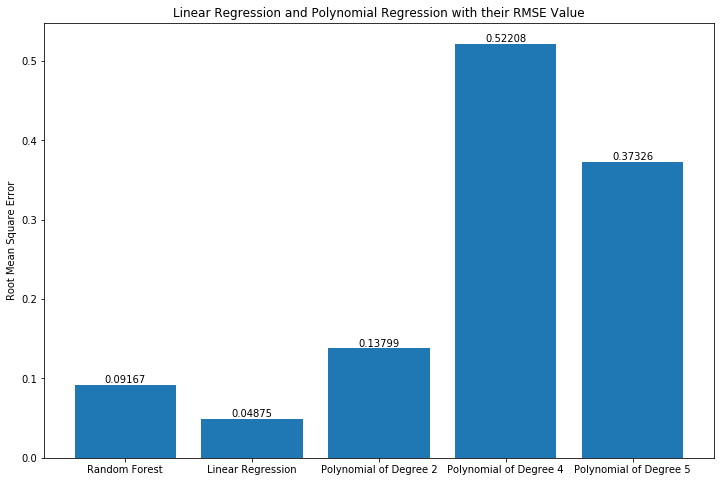

In [43]:
rmse_x = ['Random Forest', 'Linear Regression'] + ['Polynomial of Degree {}'.format(x[0]) for x in polynomial_history]
rmse_y = [rmf_rmse, lin_rmse] + [x[1] for x in polynomial_history]

plot_RMSE(rmse_x, rmse_y)

#### Therefore, In case of Regression the Minimum Value of Root Mean Square Error is seen in ***Linear Regression***

##### 2. Recursive Feature Selection on Linear Regression
We will use Wrapper Method of Recursive Feature Selection

In [0]:
lin_reg_fs = LinearRegression()
rfe = RFE(lin_reg_fs, 10)
fit = rfe.fit(x_data, y_data)

In [45]:
print("Num Features: {}".format(fit.n_features_))
print("Selected Features: {}".format(fit.support_))
print("Feature Ranking: {}".format(fit.ranking_))

Num Features: 10
Selected Features: [ True  True  True  True  True  True  True False  True False  True False
  True False]
Feature Ranking: [1 1 1 1 1 1 1 5 1 3 1 2 1 4]


In [46]:
x_feature_selected_data = rfe.transform(x_data)
x_feature_selected_data.shape

(677, 10)

Now Splitting the data to train and test set

In [47]:
x_train_fs, x_test_fs , y_train_fs, y_test_fs = train_test_split(x_feature_selected_data, y_data, test_size=0.2, random_state=SEED)
print(x_train_fs.shape, y_train_fs.shape, x_test_fs.shape, y_test_fs.shape)

(541, 10) (541,) (136, 10) (136,)


In [48]:
lin_reg_fs.fit(x_train_fs, y_train_fs)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
y_predicted = lin_reg_fs.predict(x_test_fs)

In [50]:
lin_rmse_fs = np.round(np.sqrt(mean_squared_error(y_test_fs,y_predicted)), 5)
print('Root Mean Square Error: {}'.format(lin_rmse_fs))


Root Mean Square Error: 0.04871


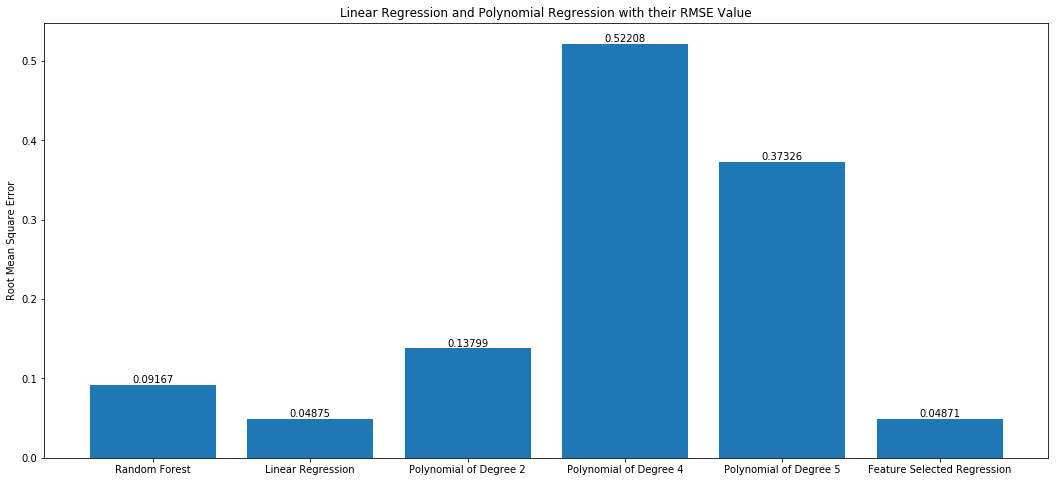

In [51]:
rmse_x = rmse_x + ['Feature Selected Regression']
rmse_y = rmse_y + [lin_rmse_fs]

plot_RMSE(rmse_x, rmse_y, (18,8))

## Feature Selection Reduced the Mean Square Error thus with Feature Selection we got a better fit

#### Applying Ridge Regularization in Linear Regression

In [0]:
lin_reg_requ = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])

In [53]:
lin_reg_requ.fit(x_train_fs, y_train_fs)

RidgeCV(alphas=array([0.001, 0.01 , 0.1  , 1.   ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [0]:
y_pred_regu = lin_reg_requ.predict(x_test_fs)

In [55]:
lin_rmse_regu = np.round(np.sqrt(mean_squared_error(y_test_fs,y_pred_regu)), 5)
print('Root Mean Square Error: {}'.format(lin_rmse_regu))

Root Mean Square Error: 0.04507


In [0]:
rmse_x = rmse_x + ['Ridge Regularization']
rmse_y = rmse_y + [lin_rmse_regu]

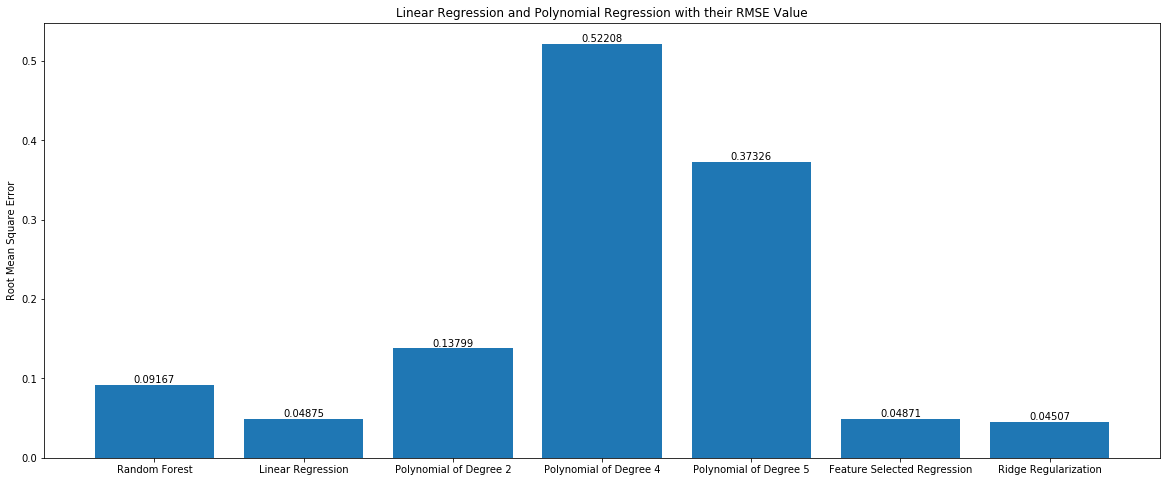

In [57]:
plot_RMSE(rmse_x, rmse_y, (20,8))

# Lets Analysis The response of Neural Netoworks in This Scenario

In [58]:
model = Sequential()

model.add(Dense(35, activation='relu', input_shape=x_train[0].shape))
model.add(Dense(100, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

W0625 00:47:04.982340 140619660339072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 00:47:04.985405 140619660339072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 00:47:04.988834 140619660339072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 00:47:05.060274 140619660339072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 35)                525       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               3600      
_________________________________________________________________
dense_3 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 49,526
Trainable params: 49,526
Non-trainable params: 0
_________________________________________________________________


In [59]:
history = model.fit(x_train, y_train, epochs=200, verbose=0)

W0625 00:47:05.192396 140619660339072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0625 00:47:05.334477 140619660339072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



In [0]:
y_predicted_nn = model.predict(x_test)

In [61]:
nn_rmse = np.round(np.sqrt(mean_squared_error(y_test,y_predicted_nn)), 5)
print('Root Mean Square Error: {}'.format(nn_rmse))

Root Mean Square Error: 0.10314


In [0]:
rmse_x = rmse_x + ['Deep Neural Network']
rmse_y = rmse_y + [nn_rmse]

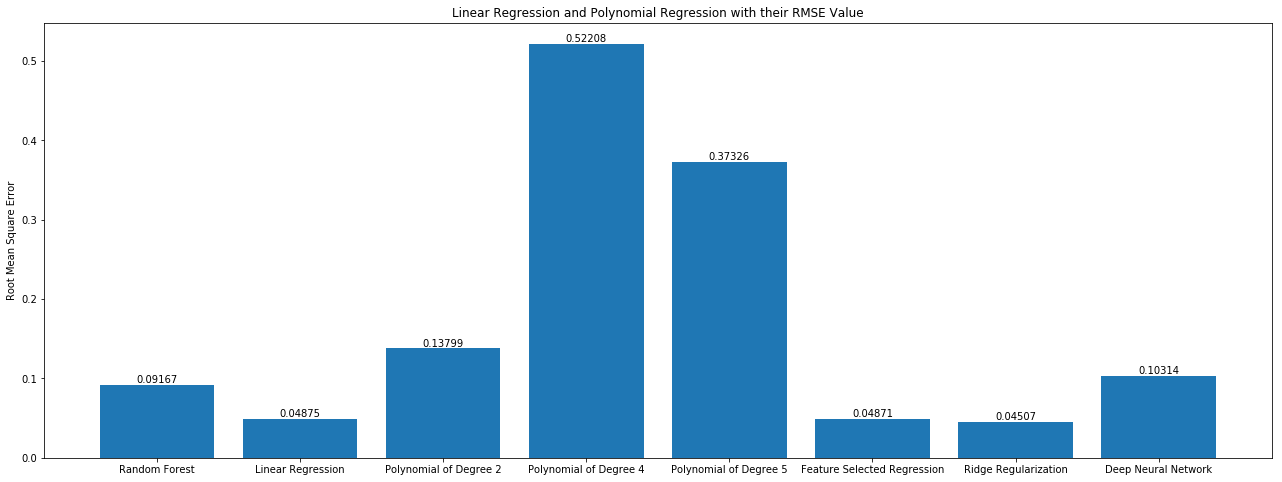

In [63]:
plot_RMSE(rmse_x, rmse_y, (22,8))

Applying Ridge Regularization in this neural network and retraining it with output we get

In [64]:
model_reg = Sequential()

model_reg.add(Dense(35, activation='relu', input_shape=x_train[0].shape, kernel_regularizer=l2(0.001)))
model_reg.add(Dropout(0.3))
model_reg.add(Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model_reg.add(Dropout(0.2))
model_reg.add(Dense(200, activation='relu', kernel_regularizer=l2(0.001)))
model_reg.add(Dropout(0.2))
model_reg.add(Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model_reg.add(Dropout(0.2))
model_reg.add(Dense(50, activation='relu', kernel_regularizer=l2(0.001)))
model_reg.add(Dropout(0.2))
model_reg.add(Dense(1))

model_reg.compile(loss='mean_squared_error', optimizer='adam')
model_reg.summary()

W0625 00:47:18.116296 140619660339072 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 35)                525       
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               3600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               20100     
__________

In [0]:
history_reg = model_reg.fit(x_train, y_train, epochs=200, verbose=0)

In [66]:
y_predicted_nn_reg = model_reg.predict(x_test)
nn_rmse_reg = np.round(np.sqrt(mean_squared_error(y_test,y_predicted_nn_reg)), 5)
print('Root Mean Square Error: {}'.format(nn_rmse_reg))

Root Mean Square Error: 0.03917


In [0]:
rmse_x = rmse_x + ['DNN Regularized']
rmse_y = rmse_y + [nn_rmse_reg]

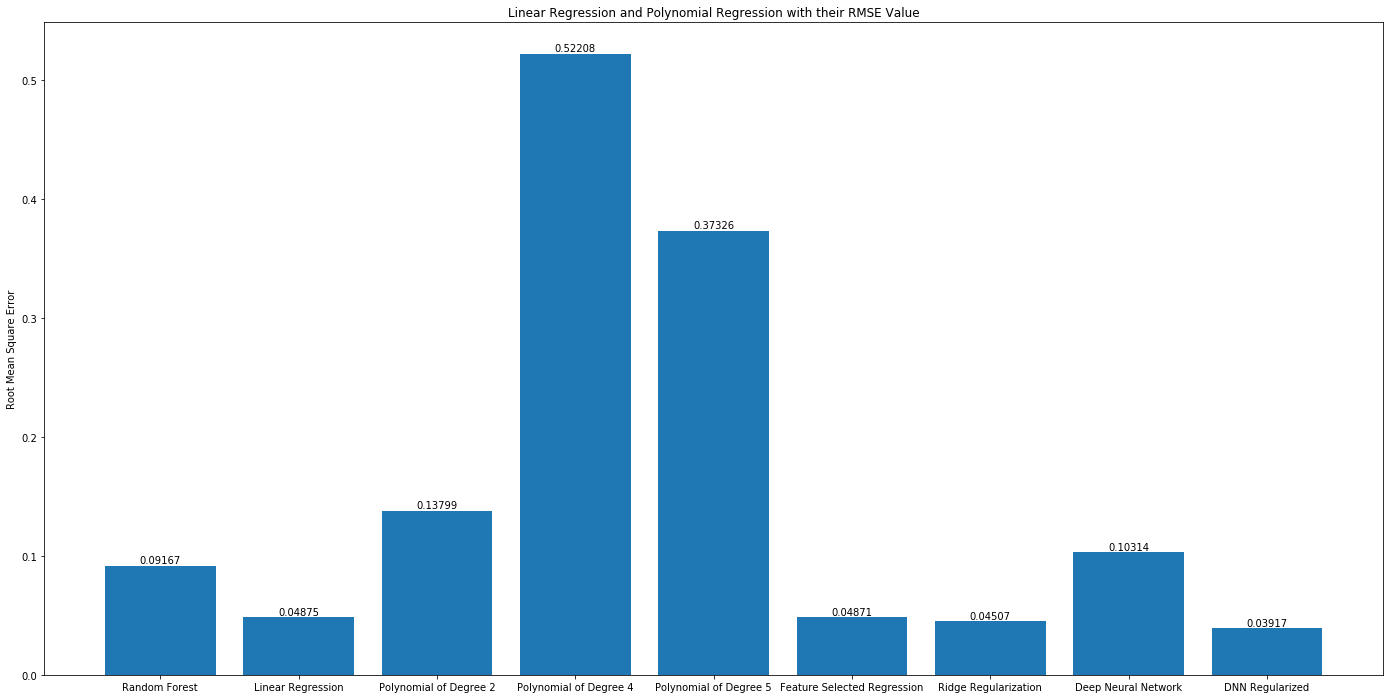

In [68]:
plot_RMSE(rmse_x, rmse_y, (24,12))

In [69]:
model_ts = Sequential()

model_ts.add(Embedding(541, 100, input_length=len(x_train[0])))
model_ts.add(Dropout(0.3))
model_ts.add(LSTM(100, activation='relu', kernel_regularizer=l2(0.001), return_sequences=True))
model_ts.add(Dropout(0.2))
model_ts.add(LSTM(200, activation='relu', kernel_regularizer=l2(0.001)))
model_ts.add(Dropout(0.2))
model_ts.add(Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model_ts.add(Dropout(0.2))
model_ts.add(Dense(50, activation='relu', kernel_regularizer=l2(0.001)))
model_ts.add(Dropout(0.2))
model_ts.add(Dense(1))

model_ts.compile(loss='mean_squared_error', optimizer='adam')
model_ts.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 14, 100)           54100     
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 100)           80400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               20100     
__________

In [70]:
history_ts = model_ts.fit(x_train, y_train, epochs=200, verbose=0)

W0625 00:47:34.875959 140619660339072 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [71]:
y_predicted_ts = model_ts.predict(x_test)
nn_rmse_ts = np.round(np.sqrt(mean_squared_error(y_test,y_predicted_ts)), 5)
print('Root Mean Square Error: {}'.format(nn_rmse_ts))

Root Mean Square Error: 0.04564


In [0]:
rmse_x = rmse_x + ['RNN Regularized']
rmse_y = rmse_y + [nn_rmse_ts]

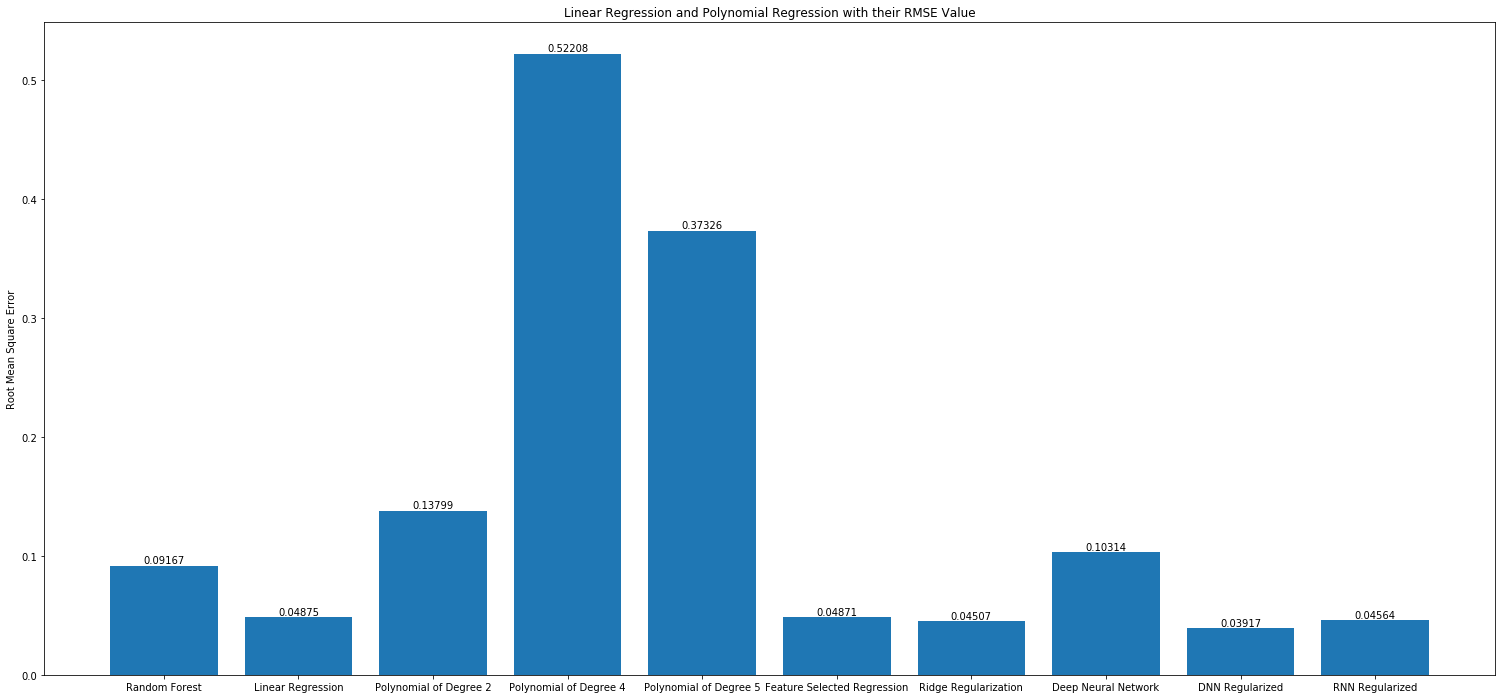

In [73]:
plot_RMSE(rmse_x, rmse_y, (26,12))

## Conclusion : 
For this dataset and This hyperparameters Models can be ranked liked this

In [0]:
result_frame = pd.DataFrame({'Model': rmse_x, 'RMSE' : rmse_y}, columns=['Model', 'RMSE']).sort_values('RMSE').reset_index(drop=True)
result_frame.index = np.arange(1, len(result_frame) + 1)
result_frame.index.names = ['Rank']

In [75]:
result_frame

,Model,RMSE
Rank,,
1,DNN Regularized,0.03917
2,Ridge Regularization,0.04507
3,RNN Regularized,0.04564
4,Feature Selected Regression,0.04871
5,Linear Regression,0.04875
6,Random Forest,0.09167
7,Deep Neural Network,0.10314
8,Polynomial of Degree 2,0.13799
9,Polynomial of Degree 5,0.37326
